## Digital Epidemiology - Group - 07
- Cruoglio Antonella
- Mascolo Davide
- Napoli Mario

TO DO:
- 1
- 2.A
- 3.D
- 4.A

# Exam
**Perform the assigned tasks in small groups and write a report**

- Each group has been assigned a subset of the following tasks. See: `https://docs.google.com/spreadsheets/d/1wNpI4yXwRNCl2rTpQEoEtfhBNTKTRaUQbhiIMB0u_HI/edit?usp=sharing`
- Some tasks are optional, do them -**at your own risk**- (after finishing the mandatory assignments).
    - Tasks 5 and 6 can be the basis for a master thesis.
    - If you decide to work on one of them, please contact us for guidance.
- Each group must produce a final report, as a python notebook, that includes both the (commented) code used to complete the tasks and a discussion of the results.
    - At the beginning of the notebook, please indicate the group and its members.
    - Send the notebooks to `s.guarino@iac.cnr.it` and `e.mastrostefano@iac.cnr.it`

In [ ]:
## Install EoN
!pip install EoN

In [ ]:
## Import utils
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import EoN
from scipy.integrate import odeint
from matplotlib.pyplot import figure
from random import sample
import timeit
import math
from collections import Counter
from scipy.stats import truncnorm

In [ ]:
## Mount Drive
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


### Step 0: initialise the network

- Download the edge list assigned to your group from the folder `https://drive.google.com/drive/folders/1vOXGz3l-Q3qTY81zXrfGuqVlRsZISI1S?usp=share_link`

- Create a graph G from the edge list (e.g., see `networkx.read_edgelist`)

In this step, we build a graph from a given edge list.

In [ ]:
## Create a graph from the edge list
edge_list = "/content/drive/MyDrive/Secondo Anno/DE/HW 02/Data/edges-7.csv"
G = nx.read_edgelist(edge_list, delimiter = ",") 

In order to see some details about the network, we can visualize the number of nodes and edges.

In [ ]:
## Number of nodes
print("Number of nodes:", len(G.nodes))
## Numer of edges
print("Number of edges:", len(G.edges))

Number of nodes: 5418
Number of edges: 26883


We computed the Connected Components of the network, and we see that there is a big component of the network contained 5356 nodes.

In [ ]:
## Connected component of the network
conn_comp = list(nx.connected_components(G))
conn_comp_len = [len(c) for c in sorted(conn_comp, key = len, reverse = True)]
print("Number of connected components: ", conn_comp_len)

Number of connected components:  [5356, 16, 8, 8, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2]


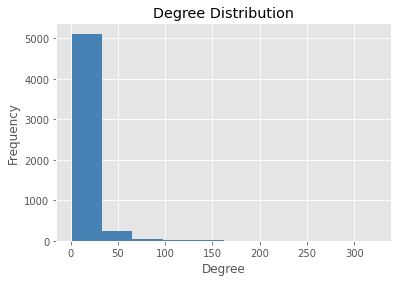

In [ ]:
## Plot the degree distribution of the network
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, color = "steelblue")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Tasks

### Task1: simulate an epidemic on G using an SIR model, comment on the results
* plot the S,I,R dynamics
* analyze the final epidemic size as beta changes when gamma is fixed (compare with the theoretical estimate)
* study the epidemic threshold (compare with the theoretical estimate)
    

The SIR model is a simple mathematical description of the spread of a disease in a population. The idea is to divide the population size $N$ into three components in relation to the time $t$:
- $S(t):$ are those susceptible but not yet infected with the disease.
- $I(t):$ is the number of infectious individuals.
- $R(t):$are those individuals who have recovered from the disease and now have immunity to it.

This model describes the change in the population of each of these components due by two parameters, β and γ. In particular:
- **β** describes the **effective contact rate** of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N).
- **γ** is the **mean recovery rate**: that is, 1/γ is the mean period of time during which an infected individual can pass it on.


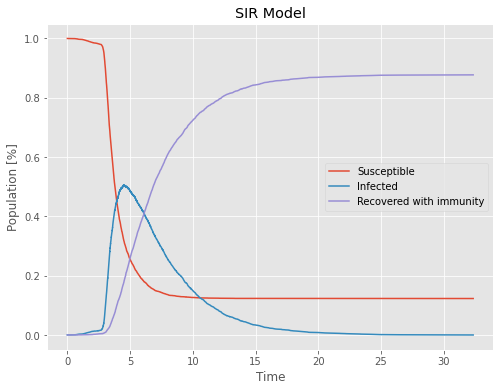

In [ ]:
plt.style.use("ggplot")
figure(figsize = (8, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N)

## Plot
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.title("SIR Model")
plt.legend()
plt.show()

Using the values of parameters defined above, we can observe that the **infected** curve has a quickly increase until the 50% of the population after that the number of infected decreases, of course this behavior is strictly related to the parameters' value and also by the time. During the diffusion of the epidemic, we will have above 90% of **recovered with immmunty**, while the number of **susceptible** individuals decreases very fast in relation to the number of infected.


Infection rate $\beta N$ in the deterministic model corresponds to infection rate $\beta$ in the complete network model:
- the infection rate in the deterministic model is the **rate** at which infected individuals make **infection-transmitting contacts**
- this rate incorporates the contact rate **and** the transmission rate
- in a complete network, each node is in contact with $\approx N$ other nodes
- by writing it as $\beta N$ we are simply decoupling the two contributions

The epidemic threshold for the deterministic/complete-graph model can now be written as $R_0 = \beta N/\gamma$.

In general, a node is in contact with $\approx \langle k \rangle$ other nodes, where $\approx \langle k \rangle$ is the **average degree** of the network.
Intuitively, this means that:
- the equivalent deterministic model has infection rate $\beta \langle k \rangle$;
- the epidemic threshold is $R_0 = \beta \langle k \rangle / \gamma$.

In [ ]:
## 2.
## Final epidemic size

## Define parameters
I0    = 1
R0    = 0
S0    = N - I0 - R0
beta_vals = [0.002, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
tmax  = 100

The **epidemic size** is defined as the **expected number of individuals that will eventually catch the disease**. The probaility that the epidemic starts and the final epidemic size depend strictly by the structure of the network. In fact, in a real case we know that there is a major probability that a disease starts if there are many contacts among people and this influences the final epidemic size.

For the task we considered different values of β.

**Epidemic threshold and size in the SIR model**

In the SIR model individuals remain infectious only until they recover.

The probability that a neighbor $u$ of a vertex $v$ who stays infected for time $\tau$ does not catch the infection is
$$\lim_{d\tau\to 0}(1-\beta(d\tau))^{\tau/d\tau}=e^{-\beta\tau}$$
or $(1-\beta)^{\tau}\approx e^{-\beta\tau}$ in discrete time.

This means that the cumulative *transmission probability* from $v$ to $u$ is
$$\phi = 1-e^{-\beta\tau}$$

If we make the simplifying assumptions that all individuals stay infected for fixed time $\tau$, we can analyze the epidemic spread through a **bond percolation process**:
- for each edge $e$, we decide beforehand whether the disease will be transmitted along $e$ (if it ever reaches either of the nodes at the ends of $e$):
    - we randomly "occupy" each edge with probability $\phi$, or not with probability $1-\phi$
    - the disease is transmitted through an edge if and only if that edge is occupied
- the disease will infect all members of the **bond percolation cluster** to which the initial carrier belongs, i.e., all nodes reachable from the initial carrier via paths that go along occupied edges:
    - for small $\phi$, there only are small clusters disconnected from one another
    - as $\phi$ increases, we get to the *percolation transition*, where the disconnected clusters grow large enough to join together and form a giant cluster
    - as $\phi$ increases still further, the giant cluster grows towards covering the entire giant connected component when $\phi=1$


For a SIR epidemic on a network having infection rate $\beta$ and average recovery time $\tau$:
- the **epidemic threshold** can be computes as the **percolation threshold** for bond percolation on the network with edge occupation probability $\phi=1-e^{-\beta\tau}$
- the **epidemic size** can be computed as the **size** of the **bond percolation clusters**

Differently from the fully-mixed SIR:
- being above the threshold does **not** guarantee a major outbreak; if $S$ is the size of the **giant percolation cluster**, with a single index case:
    - with probability $S$, the **epidemic size** is S
    - with probability $1-S$, the outbreak will be small
- percolation is a **stochastic process** and the shapes of the percolation clusters (i.e., possible epidemic size) is not predictable; we make estimates of **average** behavior, **not predictions**

Consider the bond percolation process on a CM with degree distribution $p_k$:

- Let $x$ be the average probability that a vertex is not connected to the giant percolation cluster via a specific one of its edges

$$x = \sum_k q_k (1-\phi+\phi x^k) = 1-\phi+\phi\sum_k q_k x^k = 1-\phi+\phi g_1(x)$$
(where $g_1(x)$ is the probability generating function for the excess degree distribution)

Once you find $x$ based on the latter fixed point equation, the probability that a node of total degree $k$ is not in the giant cluster is $x^k$, and the average such probability over the whole network, is
$$1-S = \sum_k p_k x^k = g_0(x)$$
so that the **expected epidemic size** is
$$S = 1- g_0(x)$$
(where $g_o(x)$ is the generating function for the degree distribution)


In [ ]:
## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Compute average degree
degrees = [val for (node, val) in G.degree()]
avg_deg = np.mean(degrees)
print("Average Degree:", round(avg_deg, 3))

Average Degree: 9.924


In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

## Theoretical Estimate
N = len(G.nodes)

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1, q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma) # cumulative transmission probability
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

Computational Time for Fast SIR simulation: 113.88 sec.


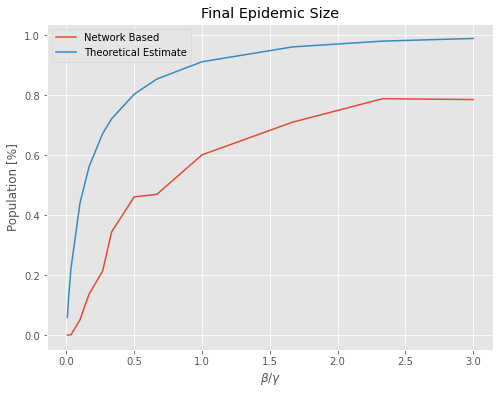

In [ ]:
## Plot
figure(figsize = (8, 6))
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size")
plt.xlabel(r"$\beta$/$\gamma$")
plt.ylabel("Population [%]")
plt.legend()
plt.show()

From this plot is possible to see the epidemic size for the network and for the theoretical estimate. The behavior of the epidemic size is network-dependent, in particular if we have a different type of topology for the network we will have a different epidemic size, while for the theoretical estimate we solved the fixed point equation. For the network based, we simulated the process 100 times for each value of beta and we see that the two curves are away from each other, so we could say that the theoretical estimate is not able to explain the behavior of the real network.

**Epidemic Threshold**

The epidemic threshold is the condition that allows the outbreak of the epidemic.

There are many ways to estimate this threshold, which depend on how much we know about the spreading disease and the connection patterns between individuals.
Here we use different estimates to find a threshold in terms of $\beta$, in such a way that if $\beta$ exceeds this threshold we expect a global epidemic.

- Deterministic (Mixing Uniform)
- Erdos Renyi
- Configuration Model

No real network belongs to these cases.


CM graph

Considering the *configuration model*, the epidemic threshold can be written as:
$$\beta\tau = -ln(1 - \phi_c) = ln\frac{\langle k^2 \rangle - \langle k \rangle}{\langle k^2 \rangle \ - \ 2 \langle k \rangle)}$$

If $\beta\tau$ exceeds this value then there is the **possibility** of an epidemic. **Not** the certainty, since the initial carrier of the disease could by chance fall outside the giant cluster.



ER graph

We know that a configuration model network with Poisson degree distribution is basically an ER graph. The only real difference is that the CM network could have multiple edges and self-edges, but their density tends to 0 in the limit of large $N$. With this model assumption the condition for the epidemic can be semplified as:

$$\frac{\beta}{\gamma}> \left(\frac{\beta}{\gamma}\right)_c = \frac{\langle k \rangle}{\langle k^2 \rangle - \langle k \rangle}$$
or as
$$\frac{\beta}{\gamma}> \frac{1}{\langle k \rangle}$$

This value in terms of $\beta$ and $\gamma$ can also be obtained using the **heterogeneous mean-field approach (HMF)**, an approach based on the statistical equivalence of all nodes of degree $k$.

Exact threshold in continuous time

The **exact threshold in continuous time** is:

$$\left(\frac{\beta}{\gamma}\right)_c^{HMF} = \frac{\langle k \rangle}{\langle k^2 \rangle - 2\langle k \rangle}$$


**Numerical identification of epidemic threshold**

Let $\rho$ be the epidemic size. 
We define the **epidemic variability** as
$$\Delta(\beta,\gamma)=\frac{\sqrt{\langle \rho^2\rangle -\langle\rho\rangle^2}}{\langle\rho\rangle}$$
where $\langle\rho\rangle$ and $\langle \rho^2\rangle$ are the average value of $\rho$ and $\rho^2$ for epidemics with the given $\beta$ and $\gamma$.
$\Delta$ is the **coefficient of variation** (or *relative standard deviation*) for the epidemic size.

We say that the **epidemic threshold** occurs at the **maximum of the epidemic variability**:
$$\left(\frac{\beta}{\gamma}\right)_c^{\Delta} = \arg \max \Delta(\beta,\gamma)$$

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
N = len(G.nodes)
I_res   = []
R0_vals = []

## Average Degree
k  = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(np.mean(R[-1]/N))
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

Computational Time for Fast SIR simulation: 118.882 sec.


In [ ]:
## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)

Beta Threshold: 0.01
Gamma Threshold: 0.3


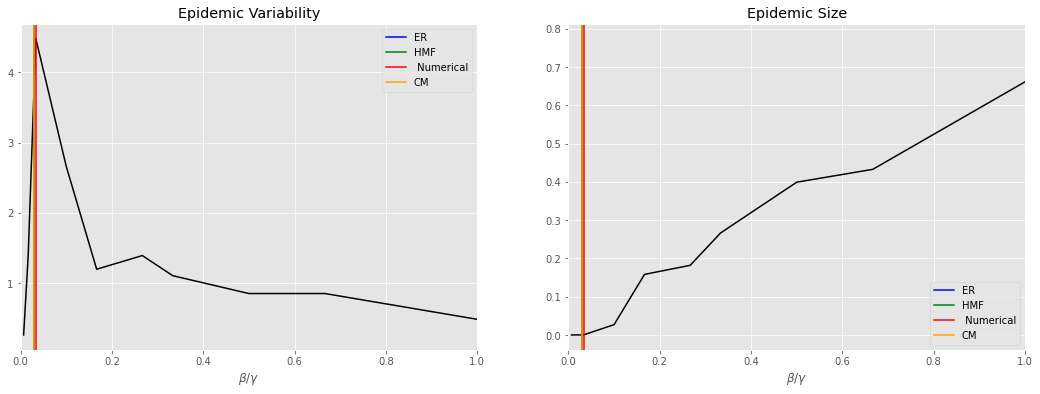

In [ ]:
## Plot
figure(figsize = (18, 6))

plt.subplot(121)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(122)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size")
plt.xlabel(r"$\beta$/$\gamma$")

plt.show()

In the first plot we have the epidemic variability for different values of $\beta/ \gamma$ and we can observe that all the approximations are similar and very close to each other.

### Task2: modify the network and repeat Task1, comment on the differences
* **[2.A]** from G, generate a random network using the two following models and repeat Task1:
    - the Configuration Model (CM) 
    - the Erdos Renyi model
    
* **[optional]** discuss the impact of the degree distribution and/or of the graph topology on the spread of the epidemic; suggested readings:
    - *Networks and epidemic models*, Keeling, Eames
    - *Epidemic outbreaks in complex heterogeneous networks*, Moreno, Pastor-Satorras, Vespignani

For this task we repeated the previous one considering two different networks.

Let's start from the Configuration Model (CM)

This model is used to generate random networks using a given degree sequence. It is often used to approximate the real-life social networks because allows to understand how an effect $X$ can increase $Y$.

In [ ]:
## 2.A Generate a random network using different models
## Configuration Model
deg_seq = [v for k, v in G.degree()]
H = nx.configuration_model(deg_seq)

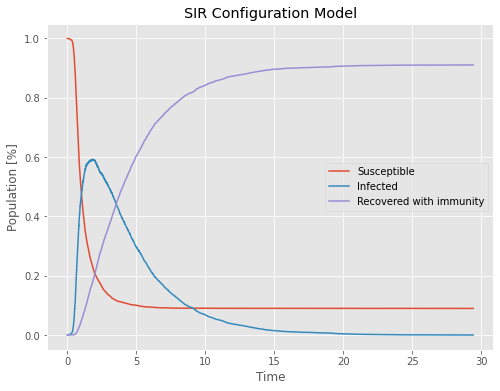

In [ ]:
## We repeat the step 1, plotting the SIR model
figure(figsize = (8, 6))
## S,I,R dynamics
N = len(H.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5 ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(H, beta, gamma, rho = 1/N)

## Plot
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Configuration Model")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Compute average degree
avg_deg_cm = np.mean(deg_seq)
print("Average Degree Configuration Model", round(avg_deg_cm, 3))

Average Degree Configuration Model 9.924


In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(H, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in H.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

Computational Time for Fast SIR simulation: 145.951 sec.


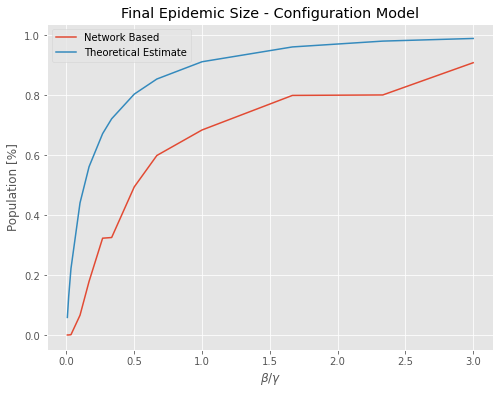

In [ ]:
## Plot
figure(figsize = (8, 6))
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Configuration Model")
plt.xlabel(r"$\beta$/$\gamma$")
plt.ylabel("Population [%]")
plt.legend()
plt.show()

Looking to the plot, transforming the original network into a Configuration Model, we observe that the two curves are not so close to each other.

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
I_res   = []
R0_vals = []

## Average Degree
k  = np.mean(deg_seq)
k2 = np.mean([d**2 for d in deg_seq])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(H, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

Computational Time for Fast SIR simulation: 110.885 sec.


In [ ]:
## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)

Beta Threshold: 0.01
Gamma Threshold: 0.3


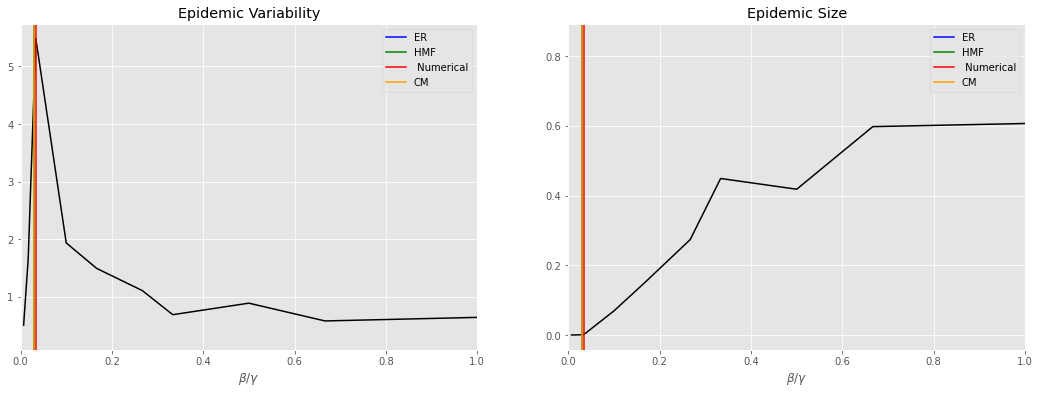

In [ ]:
## Plot
figure(figsize = (18, 6))

plt.subplot(121)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(122)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size")
plt.xlabel(r"$\beta$/$\gamma$")

plt.show()

Also in this case the thresholds are essentially the same.

At this point, we switch to Erdos Renyi network. This model is a type of random graph in which each pair of nodes is connected by probability $p$.

In [ ]:
## Erdos Renyi Network
N = len(G.nodes)
p = avg_deg / N
ER_graph = nx.erdos_renyi_graph(N, p)

In [ ]:
## Compute average degree
deg_seq = [val for key, val in ER_graph.degree()]
avg_deg_er = np.mean(deg_seq)
print("Average Degree Erdos Renyi Network:", round(avg_deg_er, 3))

Average Degree Erdos Renyi Network: 9.937


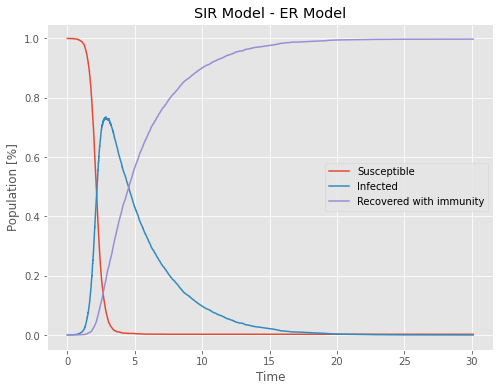

In [ ]:
## Plot SIR Model
figure(figsize = (8, 6))

## S,I,R dynamics
N = len(ER_graph.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(ER_graph, beta, gamma, rho = 1/N)

## Plot
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - ER Model")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(ER_graph, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in ER_graph.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

Computational Time for Fast SIR simulation: 162.465 sec.


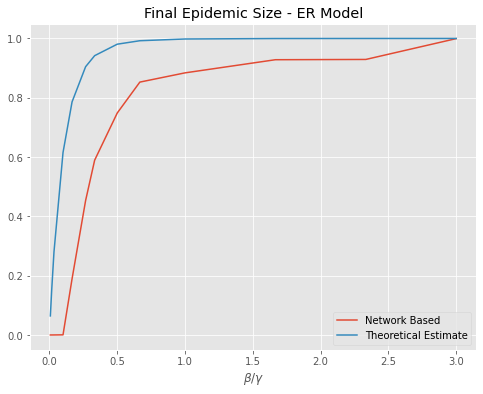

In [ ]:
## Plot
figure(figsize = (8, 6))
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - ER Model")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()
plt.show()

In this case the curves are closer to each other, with respect to the previous cases.

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
I_res   = []
R0_vals = []

## Average Degree
k  = np.mean(deg_seq)
k2 = np.mean([d**2 for d in deg_seq])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

In [ ]:
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(ER_graph, beta, gamma, rho = 1/N, tmax = tmax)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

Computational Time for Fast SIR simulation: 149.313 sec.


In [ ]:
## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)

Beta Threshold: 0.03
Gamma Threshold: 0.3


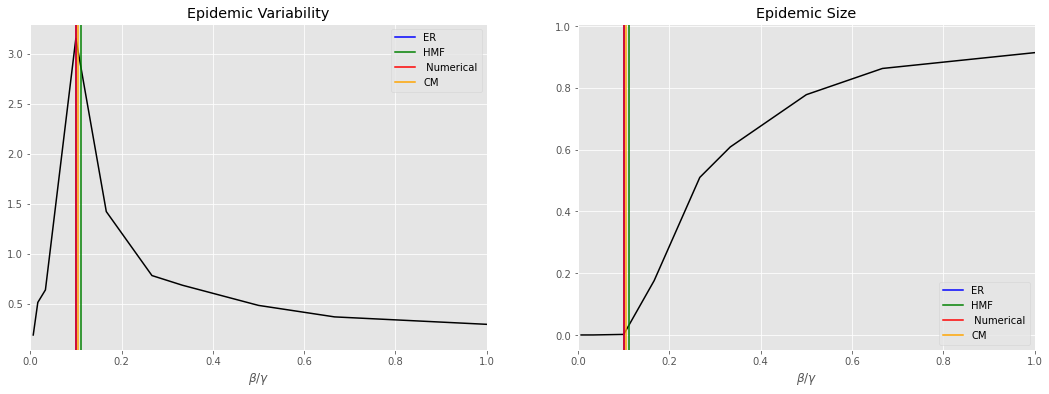

In [ ]:
## Plot
figure(figsize = (18, 6))

plt.subplot(121)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(122)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size")
plt.xlabel(r"$\beta$/$\gamma$")

plt.show()

We have that same behavior of the previous case looking to the Numerical threshold and a different value of $\beta$. Also in this case, we can observe the same results.

### Task3: immunize part of the population (with two different strategies), repeat Task1, comment on the results
- Choose a subset of individuals in two different ways:
     - at random
     - according to the following centrality metrics:  
         - **[3.D]** local clustering  
- Set these individuals as permanently immunized and repeat Task1
       

In this step we choosed a subset of infividuals to immunize using two different approaches:
- Random
- Local Clustering

We tried with different percentages in order to see if there are some differences using these values **5%, 25%, 40%**.

In [ ]:
## Local Clustering
clusters = sorted(nx.clustering(G).items(), key = lambda x: x[1], reverse = True)

## Filtered Clusters
clusters_filtered    = clusters[0:int(len(clusters) * 0.05)]
clusters_filtered    = [i[0] for i in clusters_filtered]

clusters_filtered_25 = clusters[0:int(len(clusters) * 0.25)]
clusters_filtered_25    = [i[0] for i in clusters_filtered_25]

clusters_filtered_40 = clusters[0:int(len(clusters) * 0.4)]
clusters_filtered_40    = [i[0] for i in clusters_filtered_40]

## Check
print("5% using Local Clustering:", len(clusters_filtered))
print("25% using Local Clustering:", len(clusters_filtered_25))
print("40% using Local Clustering:", len(clusters_filtered_40))

5% using Local Clustering: 270
25% using Local Clustering: 1354
40% using Local Clustering: 2167


In [ ]:
## Random
random_nodes = sample(list(G.nodes()), int(len(clusters) * 0.05))
random_nodes_25 = sample(list(G.nodes()), int(len(clusters) * 0.25))
random_nodes_40 = sample(list(G.nodes()), int(len(clusters) * 0.40))

## Check
print("5% using Random Sample", len(random_nodes))
print("25% using Random Sample", len(random_nodes_25))
print("40% using Random Sample", len(random_nodes_40))

5% using Random Sample 270
25% using Random Sample 1354
40% using Random Sample 2167


#### Local Clustering - Random Nodes 5%

As first approach, we set the **5%** of the population as permanently immunized.

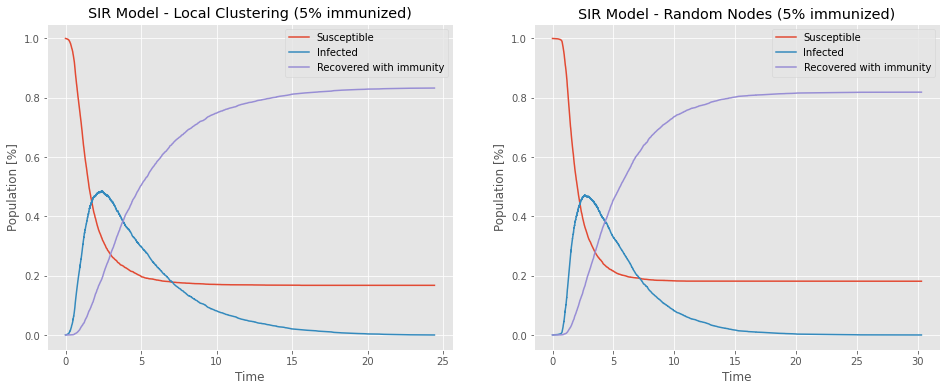

In [ ]:
## Set these individuals as permanently immunized
figure(figsize = (16, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3 ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time

## Local Clutering
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = clusters_filtered)
## Plot
plt.subplot(121)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Local Clustering (5% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

## Random Nodes
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = random_nodes)
## Plot
plt.subplot(122)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Random Nodes (5% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

Using the **5%** of immunized individuals there aren't relevant differences with the two approaches.

In [ ]:
## 2.
## Final epidemic size

## Define parameters
I0    = 1
R0    = len(clusters_filtered)
S0    = N - I0 - R0
beta_vals = [0.002, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
tmax  = 100

In [ ]:
## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

Computational Time for Fast SIR simulation with 5% immunized subjects: 105.449 sec.
Computational Time for Fast SIR simulation with 5% random immunized subjects: 72.682 sec.


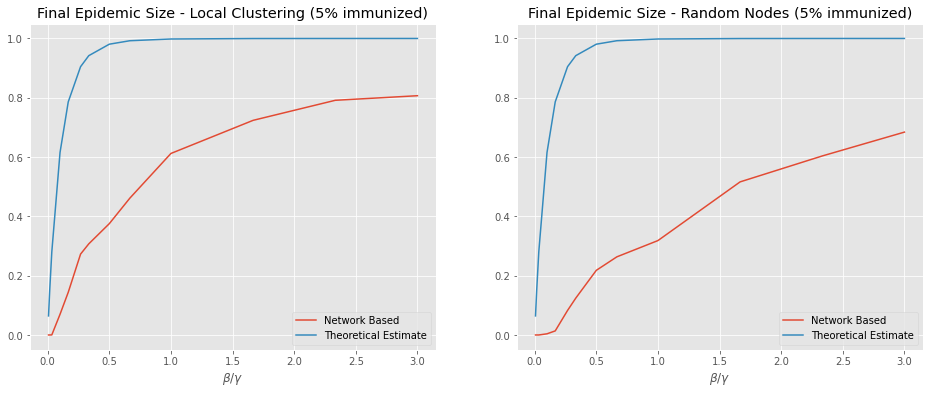

In [ ]:
## Local Clustering (5%)

## Select a node from which start the epidemic
support_G_5 = G.copy()
support_G_5.remove_nodes_from(clusters_filtered)
start_node_5 = sample(list(support_G_5), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered,
                                  initial_infecteds = start_node_5)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in ER_graph.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

figure(figsize = (16, 6))
## Plot
plt.subplot(121)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Local Clustering (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

## ************************************************************************************************************

## Random Nodes (5%)
R0    = len(random_nodes)

## Initialize empty lists
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_5 = G.copy()
support_G_5.remove_nodes_from(random_nodes)
start_node_5 = sample(list(support_G_5), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes,
                                  initial_infecteds = start_node_5)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% random immunized subjects:", round(stop - start, 3), "sec.")

## Plot
plt.subplot(122)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

plt.show()

Computational Time for Fast SIR simulation with 5% immunized subjects: 108.046 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
*********************************************************************
Computational Time for Fast SIR simulation with 5% random immunized subjects: 60.849 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
*********************************************************************


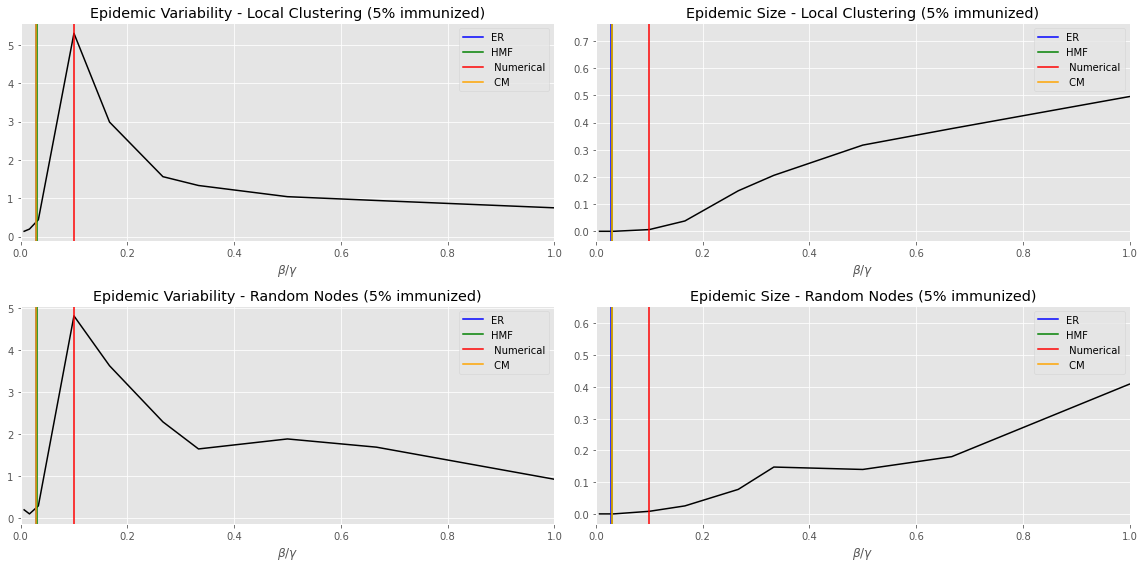

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Average Degree
k  = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered,
                                  initial_infecteds = start_node_5)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("*********************************************************************")

## Plot
figure(figsize = (16, 8))

plt.subplot(221)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Local Clustering (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(222)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Local Clustering (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

## *************************************************************************************

## Random Nodes
R0    = len(random_nodes)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes,
                                  initial_infecteds = start_node_5)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% random immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("*********************************************************************")

## Plot
plt.subplot(223)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(224)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.tight_layout()
plt.show()

As we said before, we confirm that using the 5% of immunized individuals is not enough to see if there are some differences in the two different techniques. At the same time we see that respect to the previous case, we have a greater value of $\beta$ that is due by the fact that we have more recovered.

#### Local Clustering - Random Nodes 25%

At this point, we increase the the immunized percentage to **25%**.

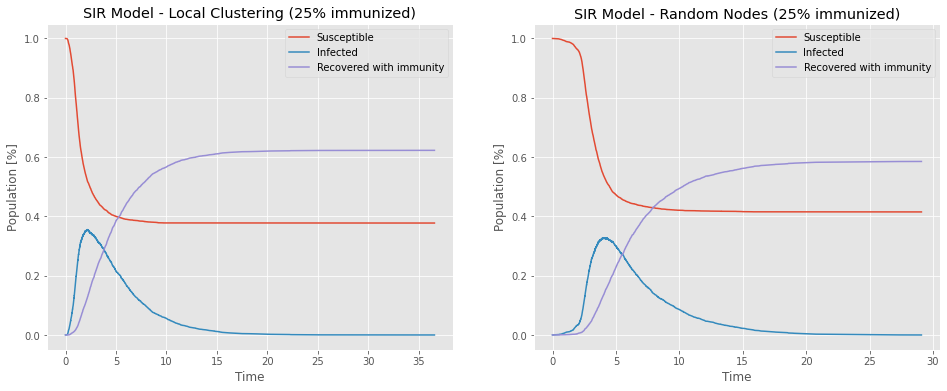

In [ ]:
## Set these individuals as permanently immunized
figure(figsize = (16, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = clusters_filtered_25)
## Plot
plt.subplot(121)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Local Clustering (25% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

## Random Nodes
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = random_nodes_25)
## Plot
plt.subplot(122)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Random Nodes (25% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

Computational Time for Fast SIR simulation with 25% immunized subjects: 76.057 sec.
Computational Time for Fast SIR simulation with 25% random immunized subjects: 45.125 sec.


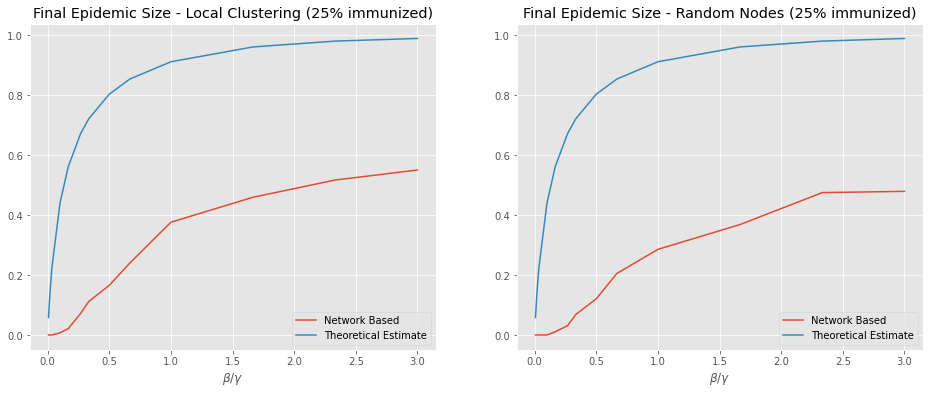

In [ ]:
## 2.
## Final epidemic size

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Local Clustering (25%)

## Select a node from which start the epidemic
support_G_25 = G.copy()
support_G_25.remove_nodes_from(clusters_filtered_25)
start_node_25 = sample(list(support_G_25), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered_25,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Plot
figure(figsize = (16, 6))
plt.subplot(121)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Local Clustering (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

## *****************************************************************************

## Random Nodes
R0    = len(random_nodes_25)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_25 = G.copy()
support_G_25.remove_nodes_from(random_nodes_25)
start_node_25 = sample(list(support_G_25), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes_25,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% random immunized subjects:", round(stop - start, 3), "sec.")

## Plot
plt.subplot(122)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Random Nodes (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

plt.show()

Also if we increase the percentage of immunized individuals, we don't see some relevant differences.

Computational Time for Fast SIR simulation with 25% immunized subjects: 54.741 sec.
Beta Threshold: 0.05
Gamma Threshold: 0.3
***********************************************************************
Computational Time for Fast SIR simulation with 25% immunized subjects: 103.145 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
*********************************************************************


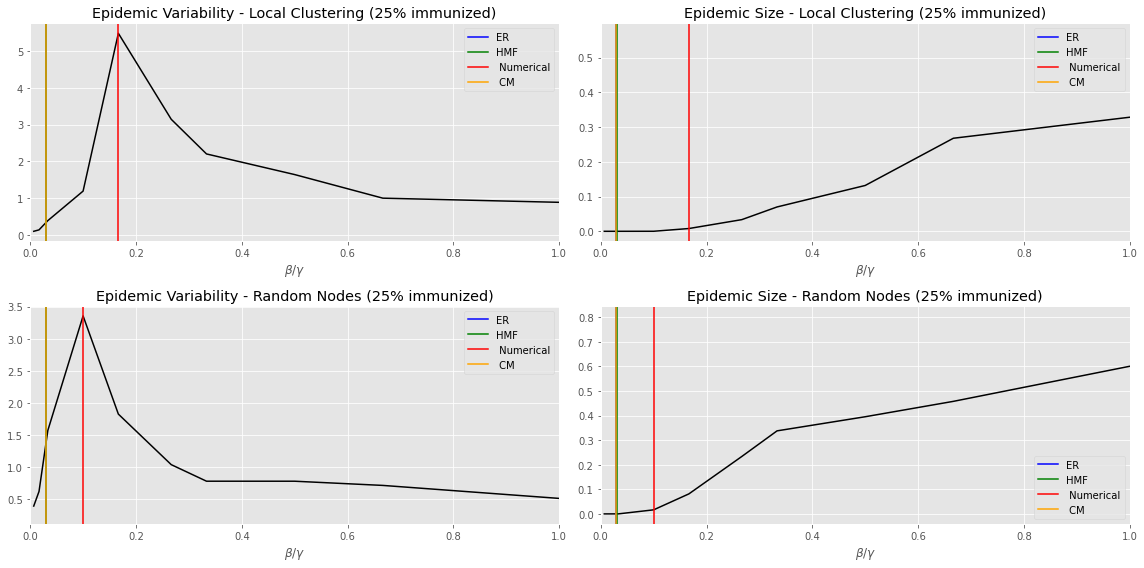

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
R_vals  = []
R0_vals = []

## Average Degree
k  = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered_25,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("***********************************************************************")

## Plot
figure(figsize = (16, 8))

plt.subplot(221)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Local Clustering (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(222)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Local Clustering (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

## ****************************************************************************

## Random nodes
R0    = len(random_nodes_25)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_25 = G.copy()
support_G_25.remove_nodes_from(random_nodes_25)
start_node_25 = sample(list(support_G_25), 1)

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("*********************************************************************")

## Plot
plt.subplot(223)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Random Nodes (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(224)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Random Nodes (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.tight_layout()
plt.show()

Using the two different approaches we obtained more or less the same behavior both for the curve of epidemic variability and for the curve of the epidemic size. For the random nodes we have a value of $\beta$ that is slightly minor.

We can note also that an epidemic size of 0.3 using random nodes approach with a $\beta$ < 0.2, while using local clustering we achieve the same value of epidemic size but with a value of $\beta$ < 0.8.

#### Local Clustering - Random Nodes 40%

At this point, we increase the the immunized percentage to **40%**.

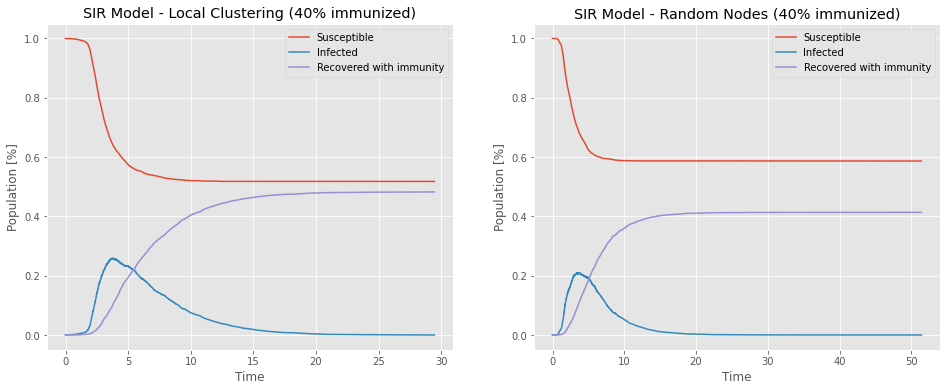

In [ ]:
## Set these individuals as permanently immunized
figure(figsize = (16, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = clusters_filtered_40)
## Plot
plt.subplot(121)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Local Clustering (40% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

## Random Nodes
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = random_nodes_40)
## Plot
plt.subplot(122)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Random Nodes (40% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

Computational Time for Fast SIR simulation with 40% immunized subjects: 59.209 sec.
Computational Time for Fast SIR simulation with 40% random immunized subjects: 34.559 sec.


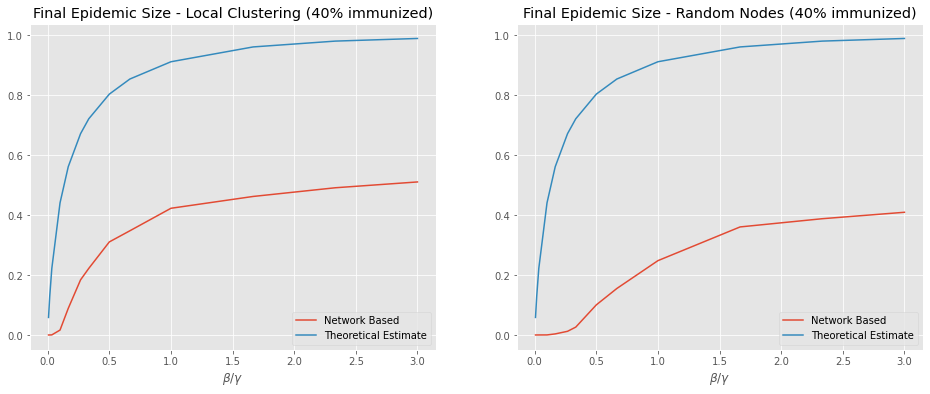

In [ ]:
## 2.
## Final epidemic size

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Local Clustering (40%)

## Select a node from which start the epidemic
support_G_40 = G.copy()
support_G_40.remove_nodes_from(clusters_filtered_40)
start_node_40 = sample(list(support_G_40), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered_40,
                                  initial_infecteds = start_node_40)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 40% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Plot
figure(figsize = (16, 6))
plt.subplot(121)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Local Clustering (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

## *****************************************************************************

## Random Nodes
R0    = len(random_nodes_25)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_40 = G.copy()
support_G_40.remove_nodes_from(random_nodes_40)
start_node_40 = sample(list(support_G_40), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes_40,
                                  initial_infecteds = start_node_40)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 40% random immunized subjects:", round(stop - start, 3), "sec.")

## Plot
plt.subplot(122)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Random Nodes (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

plt.show()

Also if we increase the percentage of immunized individuals, we don't see any difference.

Computational Time for Fast SIR simulation with 40% immunized subjects: 52.979 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
***********************************************************************
Computational Time for Fast SIR simulation with 40% immunized subjects: 38.129 sec.
Beta Threshold: 0.05
Gamma Threshold: 0.3
*********************************************************************


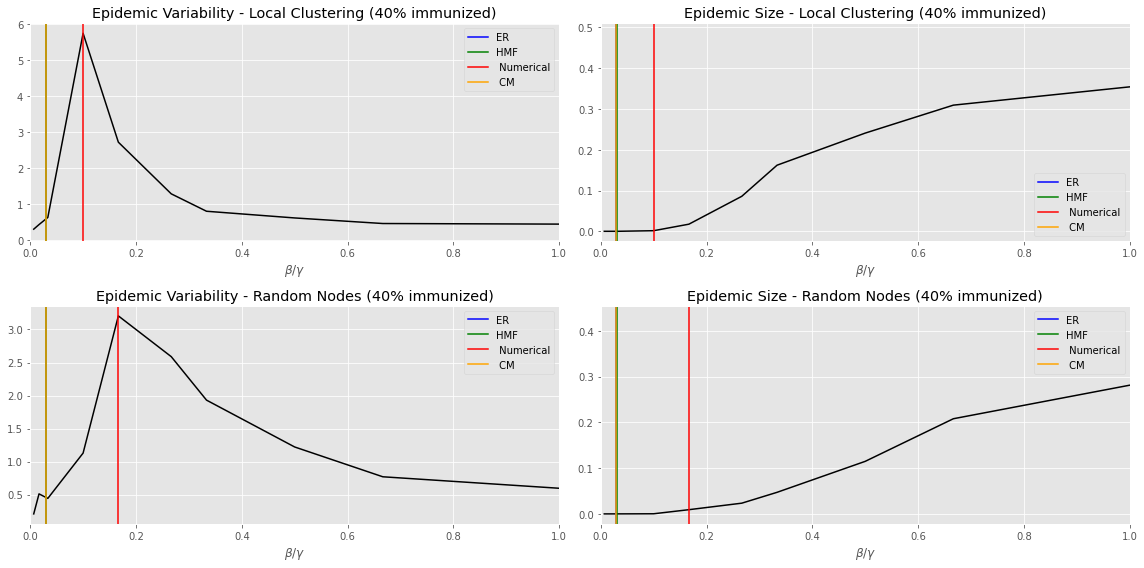

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
R_vals  = []
R0_vals = []

## Average Degree
k  = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = clusters_filtered_40,
                                  initial_infecteds = start_node_40)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 40% immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("***********************************************************************")

## Plot
figure(figsize = (16, 8))

plt.subplot(221)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Local Clustering (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(222)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Local Clustering (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

## ****************************************************************************

## Random nodes
R0    = len(random_nodes_40)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_40 = G.copy()
support_G_40.remove_nodes_from(random_nodes_40)
start_node_40 = sample(list(support_G_40), 1)

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes_40,
                                  initial_infecteds = start_node_40)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 40% immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("*********************************************************************")

## Plot
plt.subplot(223)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Random Nodes (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(224)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label =  " CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Random Nodes (40% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.tight_layout()
plt.show()

Using the local clustering to immunize different individuals, we obtained more or less the same results with respect to removing nodes in a random way. Maybe this behavior is due to the fact that to immunize the nodes with higher local clustering value doesn't mean to immunize the hubs, that are more important in the spread of an epidemic. 

So, we think that the clustering coefficient is not the most efficient measure for finding most influential nodes. We think that instead node with lower clustering coefficient have more dispersive social circle, and these nodes should be paid more attention on the immunization.

So, given that our network is approximately scale-free, we could consider the hubs, the nodes with highest degree. The scale-free networks have high capacity to survive random deletion of nodes while they're vulnerable to targeted attacks.

#### Bonus - Degree

In [ ]:
## Degree - 5% Hubs
degree = sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)
degree_filtered = degree[0:int(len(degree) * 0.05)]
degree_filtered = [i[0] for i in degree_filtered]

## Random
random_nodes = sample(list(G.nodes()), int(len(degree) * 0.05))

## Check
print("5% using Degree:", len(degree_filtered))
print("5% using Random Sample", len(random_nodes))

5% using Degree: 270
5% using Random Sample 270


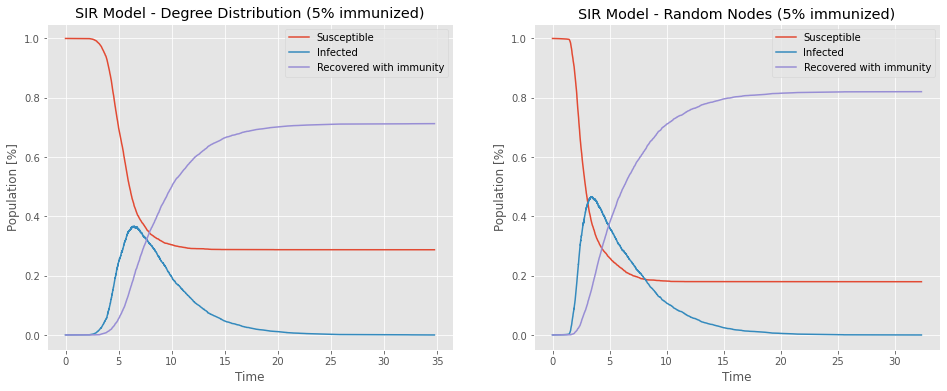

In [ ]:
## Set these individuals as permanently immunized
figure(figsize = (16, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = degree_filtered)
## Plot
plt.subplot(121)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Degree Distribution (5% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

## Random Nodes
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = random_nodes)
## Plot
plt.subplot(122)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Random Nodes (5% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()
plt.show()

Computational Time for Fast SIR simulation with 5% immunized subjects: 93.829 sec.
Computational Time for Fast SIR simulation with 5% random immunized subjects: 132.41 sec.


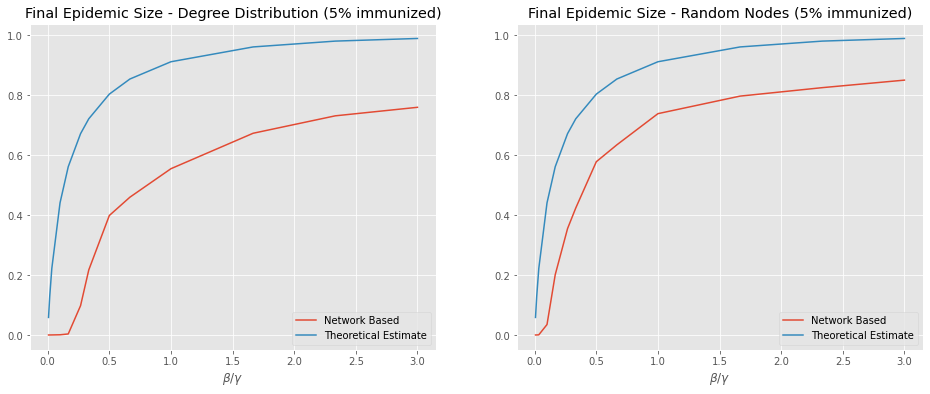

In [ ]:
## 2.
## Final epidemic size

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Degree Distribution (5%)

## Select a node from which start the epidemic
support_G = G.copy()
support_G.remove_nodes_from(degree_filtered)
start_node = sample(list(support_G), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = degree_filtered,
                                  initial_infecteds = start_node)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Plot
figure(figsize = (16, 6))
plt.subplot(121)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Degree Distribution (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

## *****************************************************************************

## Random Nodes
R0    = len(random_nodes)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G = G.copy()
support_G.remove_nodes_from(random_nodes)
start_node = sample(list(support_G), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes,
                                  initial_infecteds = start_node)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% random immunized subjects:", round(stop - start, 3), "sec.")

## Plot
plt.subplot(122)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

plt.show()

We can see that using the hubs in order to immunize some individuals, we have better results with respect to immunize the individuals based on the local clustering.

Computational Time for Fast SIR simulation with 5% immunized subjects: 79.514 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
***********************************************************************
Computational Time for Fast SIR simulation with 5% random nodes immunized subjects: 119.567 sec.
Beta Threshold: 0.03
Gamma Threshold: 0.3
*********************************************************************


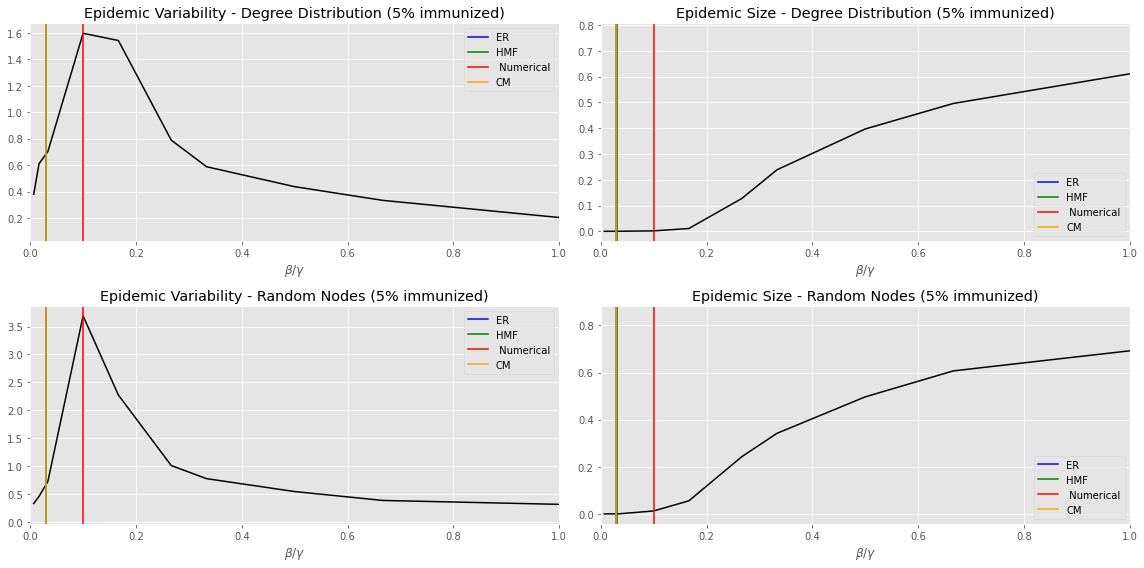

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Set some parameters
R_vals  = []
R0_vals = []

## Average Degree
k  = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k))   ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = degree_filtered,
                                  initial_infecteds = start_node)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("***********************************************************************")

## Plot
figure(figsize = (16, 8))

plt.subplot(221)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Degree Distribution (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(222)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Degree Distribution (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

## ****************************************************************************

## Random nodes
R0    = len(random_nodes_40)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G = G.copy()
support_G.remove_nodes_from(random_nodes)
start_node = sample(list(support_G), 1)

## Epidemic Size
epidemic_size = []
epidemic_variability = []

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes,
                                  initial_infecteds = start_node)
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 5% random nodes immunized subjects:", round(stop - start, 3), "sec.")

## Check
print("Beta Threshold:", beta_t)
print("Gamma Threshold:", gamma_t)
print("*********************************************************************")

## Plot
plt.subplot(223)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(224)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = epidemic_tr, color = "red", label =  " Numerical")
plt.axvline(x = beta_tau, color = "orange", label = "CM")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size - Random Nodes (5% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")

plt.tight_layout()
plt.show()

At this point, in order to have a more tangible result we want to increase the immunized percentage to **25%**.

In [ ]:
## Degree - 25% Hubs
degree = sorted(dict(G.degree()).items(), key = lambda x: x[1], reverse = True)
degree_filtered_25 = degree[0:int(len(degree) * 0.25)]
degree_filtered_25 = [i[0] for i in degree_filtered_25]

## Random
random_nodes_25 = sample(list(G.nodes()), int(len(degree) * 0.25))

## Check
print("25% using Degree:", len(degree_filtered_25))
print("25% using Random Sample", len(random_nodes_25))

25% using Degree: 1354
25% using Random Sample 1354


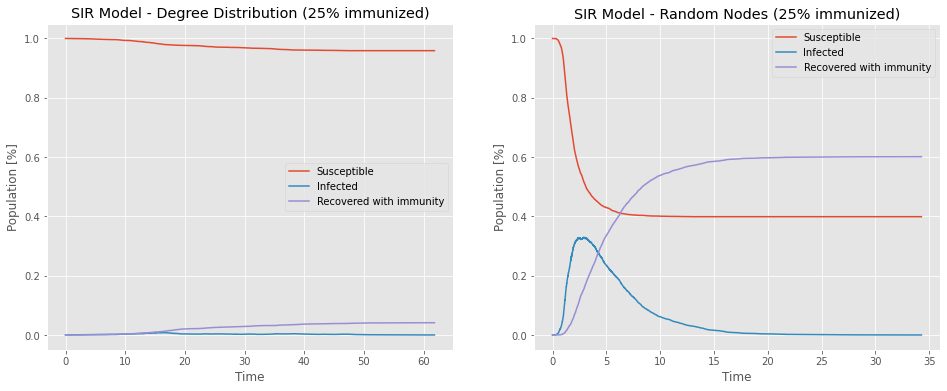

In [ ]:
## Set these individuals as permanently immunized
figure(figsize = (16, 6))

## 1.
## S,I,R dynamics
N = len(G.nodes)
gamma = 0.3  ## recovery time, how fast an individual recovers
beta  = 0.5  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = degree_filtered_25)
## Plot
plt.subplot(121)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Degree Distribution (25% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

## Random Nodes
t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = 100, initial_recovereds = random_nodes_25)
## Plot
plt.subplot(122)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.title("SIR Model - Random Nodes (25% immunized)")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.legend()

plt.show()

Computational Time for Fast SIR simulation with 25% immunized subjects: 0.403 sec.
Computational Time for Fast SIR simulation with 25% random immunized subjects: 57.07 sec.


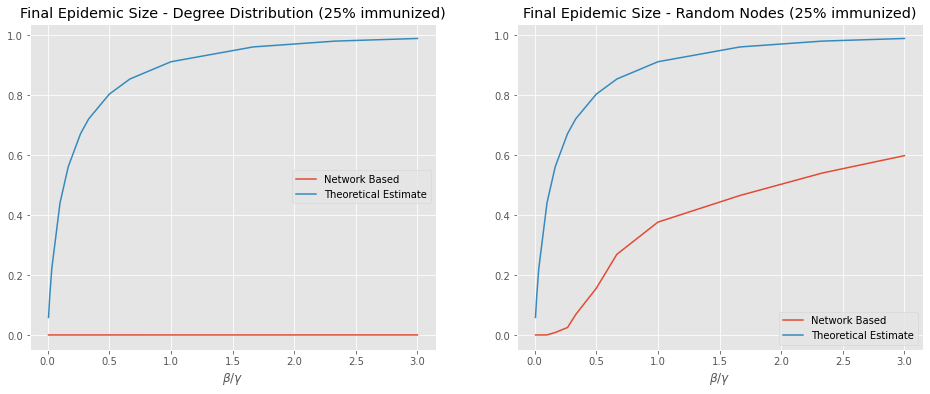

In [ ]:
## 2.
## Final epidemic size

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Degree Distribution (25%)

## Select a node from which start the epidemic
support_G_25 = G.copy()
support_G_25.remove_nodes_from(degree_filtered_25)
start_node_25 = sample(list(support_G_25), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = degree_filtered_25,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% immunized subjects:", round(stop - start, 3), "sec.")

## Select the degree sequence of the previous ER graph
deg_seq = [v for k,v in G.degree()]

## Compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
## Compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()}

## General definition of the generating function for given distribution p
def gen_fun(p,x):
    return sum([v*x**k for k,v in p.items()])

## Iterative solver for the fixed point equation
def iterative_sol(x_start,p,iters=100):
    for i in range(iters):
        x = gen_fun(p,x_start)
        x_start = x
    return x    

## Apply
x_sol = iterative_sol(0.1,q_k)
sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)

## Plot
figure(figsize = (16, 6))
plt.subplot(121)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Degree Distribution (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

## *****************************************************************************

## Random Nodes
R0    = len(random_nodes)

## Initialize empty lists
R_vals  = []
R0_vals = []

## Create dict
n_runs = 100
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Select a node from which start the epidemic
support_G_25 = G.copy()
support_G_25.remove_nodes_from(random_nodes_25)
start_node_25 = sample(list(support_G_25), 1)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, tmax = tmax, initial_recovereds = random_nodes_25,
                                  initial_infecteds = start_node_25)
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation with 25% random immunized subjects:", round(stop - start, 3), "sec.")

## Plot
plt.subplot(122)
ep_size = [r/N for r in runs["R"]]
plt.plot(R0_vals, ep_size, label = "Network Based")
plt.plot(R0_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size - Random Nodes (25% immunized)")
plt.xlabel(r"$\beta$/$\gamma$")
plt.legend()

plt.show()

   ### Task4: change the epidemic model, repeat Task1 and comment on the differences
- **[4.A]** instead of using a constant recovery rate for all nodes, assign the rate to each individual from a probability distribution and repeat Task1; use the following three distributions:
    - gaussian 
    - power-law
    - uniform (0,1)

Restart the runtime and mount again the drive.

In [ ]:
## Import utils
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import EoN
from scipy.integrate import odeint
from matplotlib.pyplot import figure
from random import sample

In [ ]:
## Create a graph from the edge list
edge_list = "/content/drive/MyDrive/edges-7.csv"
G = nx.read_edgelist(edge_list, delimiter = ",") 
N = len(G.nodes)

* Gaussian Distribution

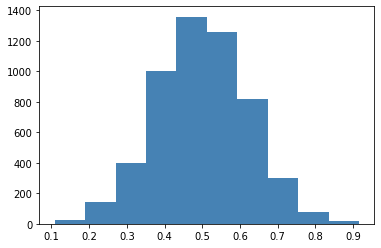

In [ ]:
## Truncated Normal
def get_truncated_normal(mean = 0.5, sd = 0.12, low = 0, upp = 1):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc = mean, scale = sd)
plt.hist(get_truncated_normal().rvs(N), color = "steelblue")
plt.show()

In [ ]:
!pip install powerlaw
import powerlaw

* Power Law Distribution

We divide all the elements of the distribution to get only weights in [0,1]

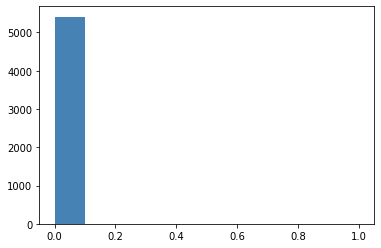

In [ ]:
power_law_dist = powerlaw.Power_Law(parameters=[2], discrete=False, xmax=1)

simulated_data = power_law_dist.generate_random(N)
power_sim = [data/np.max(simulated_data) for data in simulated_data]
plt.hist(power_sim, color = "steelblue")
plt.show()

* Uniform Distribution

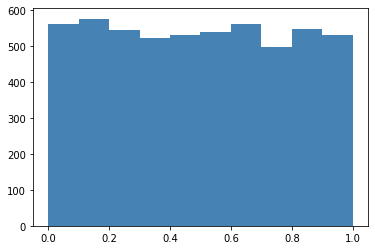

In [ ]:
plt.hist(np.random.uniform(size = N), color = "steelblue")
plt.show()

#### SIR Model

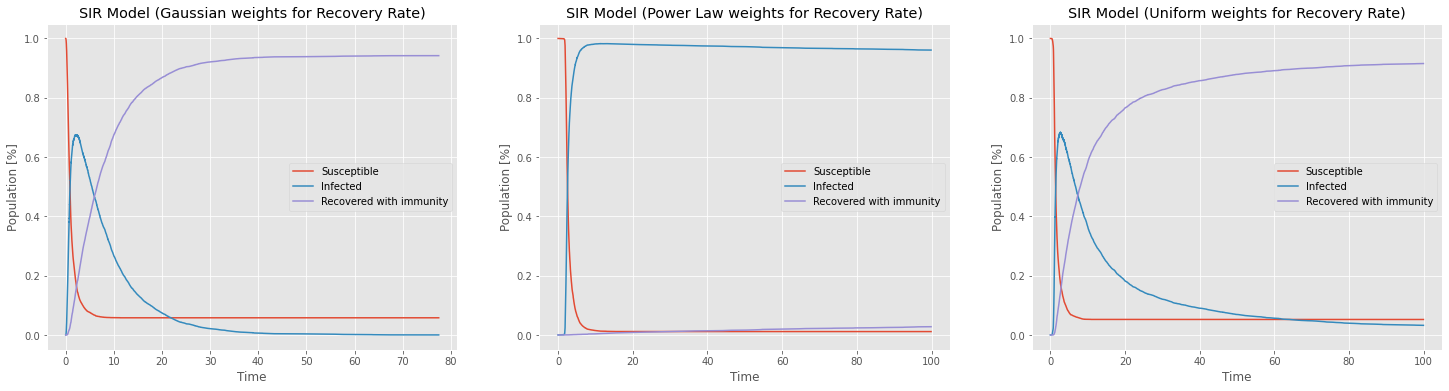

In [ ]:
## 1.
## S,I,R dynamics
N = len(G.nodes)
tmax = 100
gamma = 0.3 ## recovery time, how fast an individual recovers
beta = 0.7  ## higher ---> more trasmission expected in a time


## ***GAUSSIAN***
## Assign Gaussian weights
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = get_truncated_normal().rvs()

t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")

## Plot
plt.figure(figsize = (25,6))
plt.subplot(131)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.title("SIR Model (Gaussian weights for Recovery Rate)")
plt.legend()

## ***POWER LAW***
## Assing Power Law weights
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = sample(power_sim,1)[0]

## 1.
## S,I,R dynamics
N = len(G.nodes)
tmax = 100
gamma = 0.3 ## recovery time, how fast an individual recovers
beta = 0.7  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")

## Plot
plt.subplot(132)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.title("SIR Model (Power Law weights for Recovery Rate)")
plt.legend()

## ***UNIFORM***
## Assing Uniform weights
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = np.random.uniform()

## 1.
## S,I,R dynamics
N = len(G.nodes)
tmax = 100
gamma = 0.3 ## recovery time, how fast an individual recovers
beta = 0.7  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")

## Plot
plt.subplot(133)
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.title("SIR Model (Uniform weights for Recovery Rate)")
plt.legend()
plt.show()

It's possible to observe a similar behavior of the SIR model for the 1st and the 3rd case (Gaussian weights and Uniform weights). A different thing happens for the case in which the recovery weights are distributed according to a power law distribution: here the number of infected increases very fast and almost the entire population stays infected for a long time. This is due to the fact that the weights are very low, so the recovery rate is small for the majority of the individuals and the outbreak size is huge. 

In particular, for the second case:

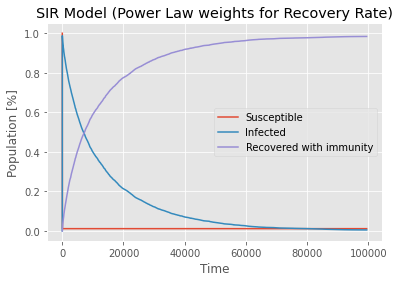

In [ ]:
## ***POWER LAW***
## Assing Power Law weights
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = sample(power_sim,1)[0]

## 1.
## S,I,R dynamics
N = len(G.nodes)
tmax = 100000
gamma = 0.3 ## recovery time, how fast an individual recovers
beta = 0.7  ## higher ---> more trasmission expected in a time
t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")

## Plot
plt.plot(t, S/N, label = "Susceptible")
plt.plot(t, I/N, label = "Infected")
plt.plot(t, R/N, label = "Recovered with immunity")
plt.ylabel("Population [%]")
plt.xlabel("Time")
plt.title("SIR Model (Power Law weights for Recovery Rate)")
plt.legend()
plt.show()

### Final Epidemic Size

In [ ]:
## 2. Final Epidemic Size
I0    = 1
R0    = 0
S0    = N - I0 - R0
gamma = 0.3
beta_vals = [0.002, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
tmax  = 100
n_runs = 100

Computational Time for Fast SIR simulation: 137.524 sec.
Computational Time for Fast SIR simulation: 224.044 sec.
Computational Time for Fast SIR simulation: 119.374 sec.


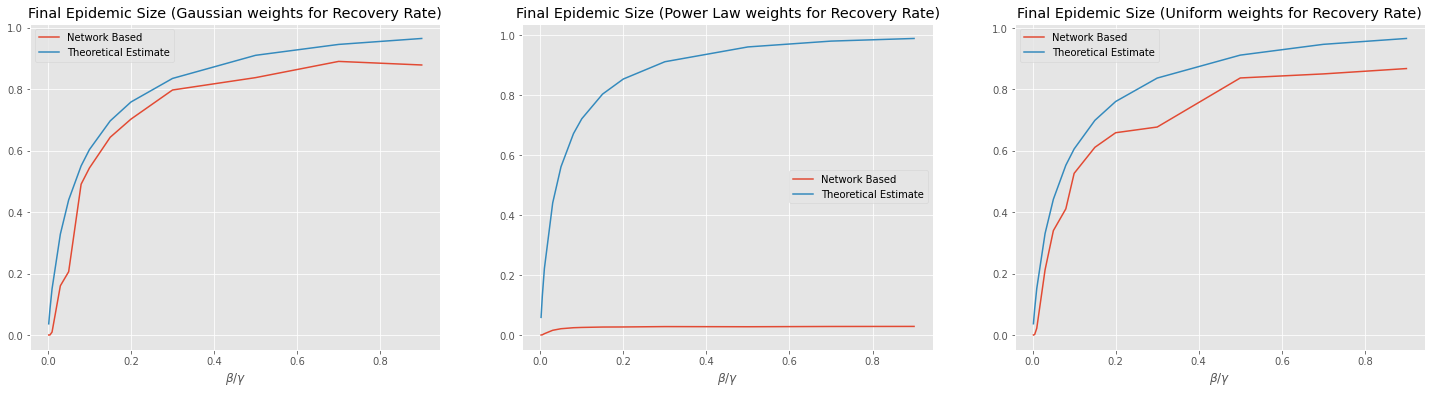

In [ ]:
## Initialize empty lists
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []

runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Compute average degree
degrees = [val for (node, val) in G.degree()]
avg_deg = np.mean(degrees)

## ***GAUSSIAN**
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = get_truncated_normal().rvs()

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

deg_seq = [v for k,v in G.degree()]

# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/mean_gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
plt.figure(figsize = (25,6))
plt.subplot(131)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
# plt.plot(R0_vals_det, R_vals_det, label = "Deterministic")
plt.title("Final Epidemic Size (Gaussian weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()



## ***POWER LAW***
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []


runs = {"t":[], "I(t)":[], "run":[], "R":[]}

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = sample(power_sim,1)[0]

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/mean_gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

deg_seq = [v for k,v in G.degree()]

# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
# plt.figure(figsize = (25,6))
plt.subplot(132)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
# plt.plot(R0_vals_det, R_vals_det, label = "Deterministic")
plt.title("Final Epidemic Size (Power Law weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()


## **UNIFORM**
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []


runs = {"t":[], "I(t)":[], "run":[], "R":[]}

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = np.random.uniform()

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

## Deterministic model
start = timeit.default_timer()

deg_seq = [v for k,v in G.degree()]
# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/mean_gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
# plt.figure(figsize = (25,6))
plt.subplot(133)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
# plt.plot(R0_vals_det, R_vals_det, label = "Deterministic")
plt.title("Final Epidemic Size (Uniform weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()

plt.show()

but if we increase the tmax for the second case...

Computational Time for Fast SIR simulation: 136.037 sec.
Computational Time for Fast SIR simulation: 327.202 sec.
Computational Time for Fast SIR simulation: 128.384 sec.


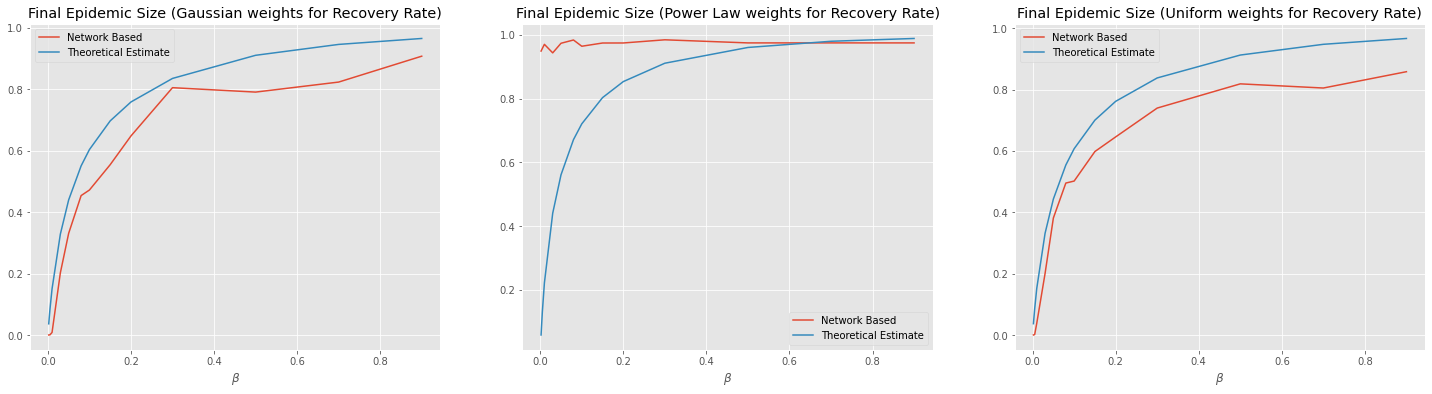

In [ ]:

## 2.
## Final epidemic size

## Define parameters
I0    = 1
R0    = 0
S0    = N - I0 - R0
beta_vals = [0.002, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
tmax  = 100
n_runs = 100

R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []

runs = {"t":[], "I(t)":[], "run":[], "R":[]}

## Compute average degree
degrees = [val for (node, val) in G.degree()]
avg_deg = np.mean(degrees)

## ***GAUSSIAN**
for n in G.nodes:
    G.nodes[n]["recovery_weight"] = get_truncated_normal().rvs()

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

deg_seq = [v for k,v in G.degree()]

# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/mean_gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
plt.figure(figsize = (25,6))
plt.subplot(131)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
# plt.plot(R0_vals_det, R_vals_det, label = "Deterministic")
plt.title("Final Epidemic Size (Gaussian weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()



## ***POWER LAW***
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []


runs = {"t":[], "I(t)":[], "run":[], "R":[]}

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = sample(power_sim,1)[0]

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = 100000, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/mean_gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

deg_seq = [v for k,v in G.degree()]

# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
plt.subplot(132)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
plt.title("Final Epidemic Size (Power Law weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()


## **UNIFORM**
R_vals  = []
R0_vals = []
R_vals_det  = []
R0_vals_det = []


runs = {"t":[], "I(t)":[], "run":[], "R":[]}

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = np.random.uniform()

gamma_weights = [G.nodes[n]["recovery_weight"]  for n in G.nodes]
mean_gamma = np.median(gamma_weights)

## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1])
    R0_vals.append(beta/gamma)
    runs["R"].append(np.mean(R_avg))
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")

## Deterministic model
start = timeit.default_timer()

deg_seq = [v for k,v in G.degree()]
# compute the degree distribution
p_k = {k:v/N for k,v in Counter(deg_seq).items()}
# compute the mean degree and the excess degree distribution
k_mean = np.mean(deg_seq)
q_k = {k-1:k/k_mean*v for k,v in p_k.items()} 

x_sol = iterative_sol(0.1,q_k)

sizes = []
for beta in beta_vals:
    phi = 1 - np.exp(-beta/mean_gamma)
    x = 1 - phi + phi*gen_fun(q_k,x_sol)
    S = 1-gen_fun(p_k,x)
    sizes.append(S)


es_runs = [r/N for r in runs['R']]
## Plot
# plt.figure(figsize = (25,6))
plt.subplot(133)
plt.plot(beta_vals, es_runs, label = "Network Based")
plt.plot(beta_vals, sizes, label = "Theoretical Estimate")
# plt.plot(R0_vals_det, R_vals_det, label = "Deterministic")
plt.title("Final Epidemic Size (Uniform weights for Recovery Rate)")
plt.xlabel(r"$\beta$")
plt.legend()

plt.show()

### Epidemic Threshold

In [ ]:
## 3.
## Epidemic threshold (compare with the theoretical estimate)

## Average Degree
degrees = [val for (node, val) in G.degree()]
k = np.mean(degrees)
k2 = np.mean([d**2 for d in degrees])

## Compute epidemic thresholds
beta_tau       = np.log((k2 - k) / (k2 - 2*k)) ## CM
beta_gamma_er  = k / (k2 - k)                    ## ER
beta_gamma_hmf = k / (k2 - 2*k)                  ## HMF

## Create dict
runs = {"t":[], "I(t)":[], "run":[], "R":[]}

Computational Time for Fast SIR simulation: 152.756 sec.
Computational Time for Deterministic Model: 0.021 sec.
Beta Threshold (Gaussian weights): 0.01
Gamma Threshold (Gaussian weights): 0.3
Computational Time for Fast SIR simulation: 56.146 sec.
Computational Time for Deterministic Model: 0.021 sec.
Beta Threshold (Power Law weights): 0.03
Gamma Threshold (Power Law weights): 0.3
Computational Time for Fast SIR simulation: 121.108 sec.
Computational Time for Deterministic Model: 0.021 sec.
Beta Threshold (Uniform weights): 0.005
Gamma Threshold (Uniform weights): 0.3


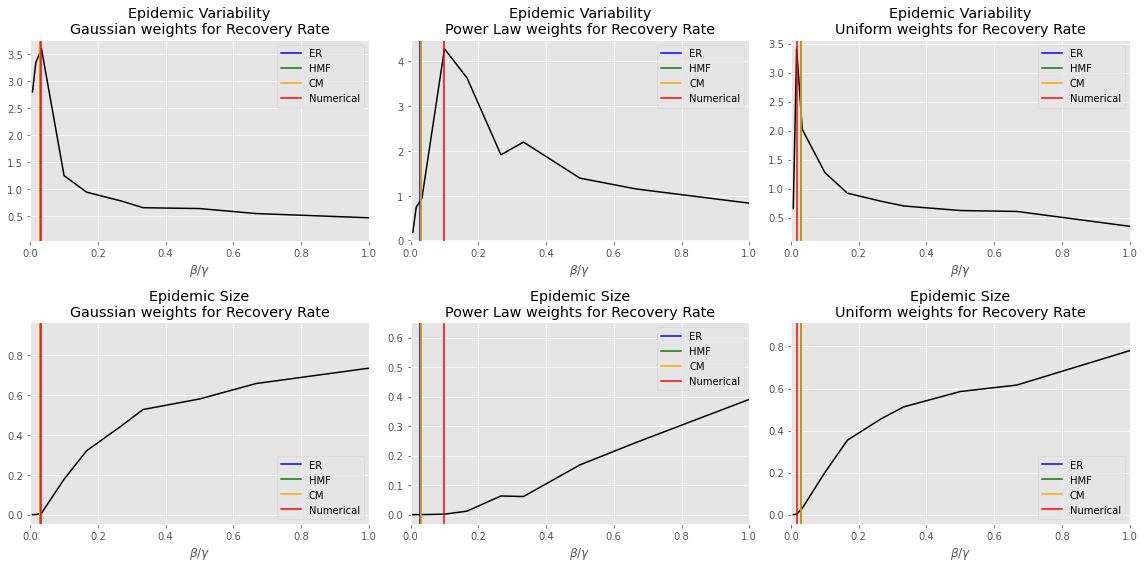

In [ ]:
## ***GAUSSIAN***
## Set some parameters
I_res   = []
R0_vals = []

## Epidemic Size
epidemic_size = []
epidemic_variability = []

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = get_truncated_normal().rvs()
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")




## Check
print("Beta Threshold (Gaussian weights):", beta_t)
print("Gamma Threshold (Gaussian weights):", gamma_t)

plt.figure(figsize = (16,8))

plt.subplot(231)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability\nGaussian weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(234)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size\nGaussian weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")


## ***POWER LAW***
## Set some parameters
I_res   = []
R0_vals = []

## Epidemic Size
epidemic_size = []
epidemic_variability = []

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = power_law_dist.generate_random(1)[0]
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")



## Check
print("Beta Threshold (Power Law weights):", beta_t)
print("Gamma Threshold (Power Law weights):", gamma_t)

plt.subplot(232)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability\nPower Law weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(235)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size\nPower Law weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")


## ***UNIFORM***
## Set some parameters
I_res   = []
R0_vals = []

## Epidemic Size
epidemic_size = []
epidemic_variability = []

for n in G.nodes:
    G.nodes[n]["recovery_weight"] = np.random.uniform()
## We test the model for different values of beta and for different simulations
start = timeit.default_timer()
for beta in beta_vals:
    R_avg = []
    for i in range(n_runs):
        t, S, I, R = EoN.fast_SIR(G, beta, gamma, rho = 1/N, tmax = tmax, recovery_weight = "recovery_weight")
        R_avg.append(R[-1]/N)
    ## Epidemic Size
    epidemic_size.append(R_avg)
    R0_vals.append(beta/gamma)
## Epidemic variability
epidemic_variability = [math.sqrt(np.mean([i**2 for i in el]) - np.mean(el) ** 2) / np.mean(el) for el in epidemic_size]
epidemic_size = [np.mean(ep) for ep in epidemic_size]
idx = np.argmax(epidemic_variability)
## Epidemic Threshold
epidemic_tr = R0_vals[idx]
beta_t  = beta_vals[idx]
gamma_t = gamma
stop = timeit.default_timer()
print("Computational Time for Fast SIR simulation:", round(stop - start, 3), "sec.")



## Check
print("Beta Threshold (Uniform weights):", beta_t)
print("Gamma Threshold (Uniform weights):", gamma_t)

plt.subplot(233)
plt.plot(R0_vals, epidemic_variability, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Variability\nUniform weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")

plt.subplot(236)
plt.plot(R0_vals, epidemic_size, color = "black")
plt.axvline(x = beta_gamma_er, color = "blue", label = "ER")
plt.axvline(x = beta_gamma_hmf, color = "green", label = "HMF")
plt.axvline(x = beta_tau, color = "orange", label =  "CM")
plt.axvline(x = epidemic_tr, color = "red", label =  "Numerical")
plt.xlim(0, 1)
plt.legend()
plt.title("Epidemic Size\nUniform weights for Recovery Rate")
plt.xlabel(r"$\beta$/$\gamma$")
plt.tight_layout()
plt.show()

For the 1st and the 3rd case all the estimates are more or less the same, while for the case of the power law distribution the numerical estimate is not so close to the others.